# Assignment — Random graphs

In [1]:
from zlib import adler32
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import requests
import networkx as nx
import scipy.stats as st
import numpy as np

### Task 1. Erdos-Renyi model (0 points)

Implement Erdos Renyi model (random graph) — each pair of $n$ nodes are connected with some fixed probability $p$.

In [2]:
def erdos_renyi_graph(n, p):
    G = nx.Graph()
    nodes = np.arange(n)
    G.add_nodes_from(nodes)
    G.add_edges_from(random_edges(nodes, p))
    return G

Write a function `random_edges` with parameters: `nodes` — np.array of nodes, for example [1, 2, 3, 4, ...] and `p` — probability of connection. The function returns np.array with tuples of the form [(1, 2), (2, 4), ...], where 1-2, 2-4 are edges that should be added in the graph.

*Hint: To speed up the generation, look at ALG.1 in the article [Efficient generation of large random networks](http://vlado.fmf.uni-lj.si/pub/networks/doc/ms/rndgen.pdf).*

In [3]:
def random_edges(nodes, p):
    from random import uniform

    # Set the variables
    edges = []
    num_nodes = len(nodes)
    curr_vertex = 1
    can_vertex = -1

    # while not all vertices
    while curr_vertex < num_nodes:
        # draw r from 0 to 1
        r = uniform(0, 1)
        
        # get new candidate vertex
        can_vertex += 1 + np.floor(np.log(1 - r) /  np.log(1-p))

        # do the evolving graph thing
        # traversal of each row corresponds to the creation of a new vertex
        while can_vertex >= curr_vertex and curr_vertex < num_nodes:
            can_vertex -= curr_vertex
            curr_vertex += 1

        # add edge
        if curr_vertex < num_nodes:
            edges.append([curr_vertex, can_vertex])
    
    return np.array(edges).astype(int)


In [4]:
'''Check the Erdos-Renyi random graph generation'''
assert len(erdos_renyi_graph(100, 0.1).edges) > 0
n = 100
p = 0.4
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 1000
p = 0.01
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma
n = 300
p = 0.9
n_edges = n * (n-1) / 2
q = 1 - p
sigma = np.sqrt((p * q) / n_edges)
assert  p - 3*sigma < random_edges(np.arange(n), p).shape[0] / n_edges < p + 3*sigma

Let us draw a couple of generated graphs

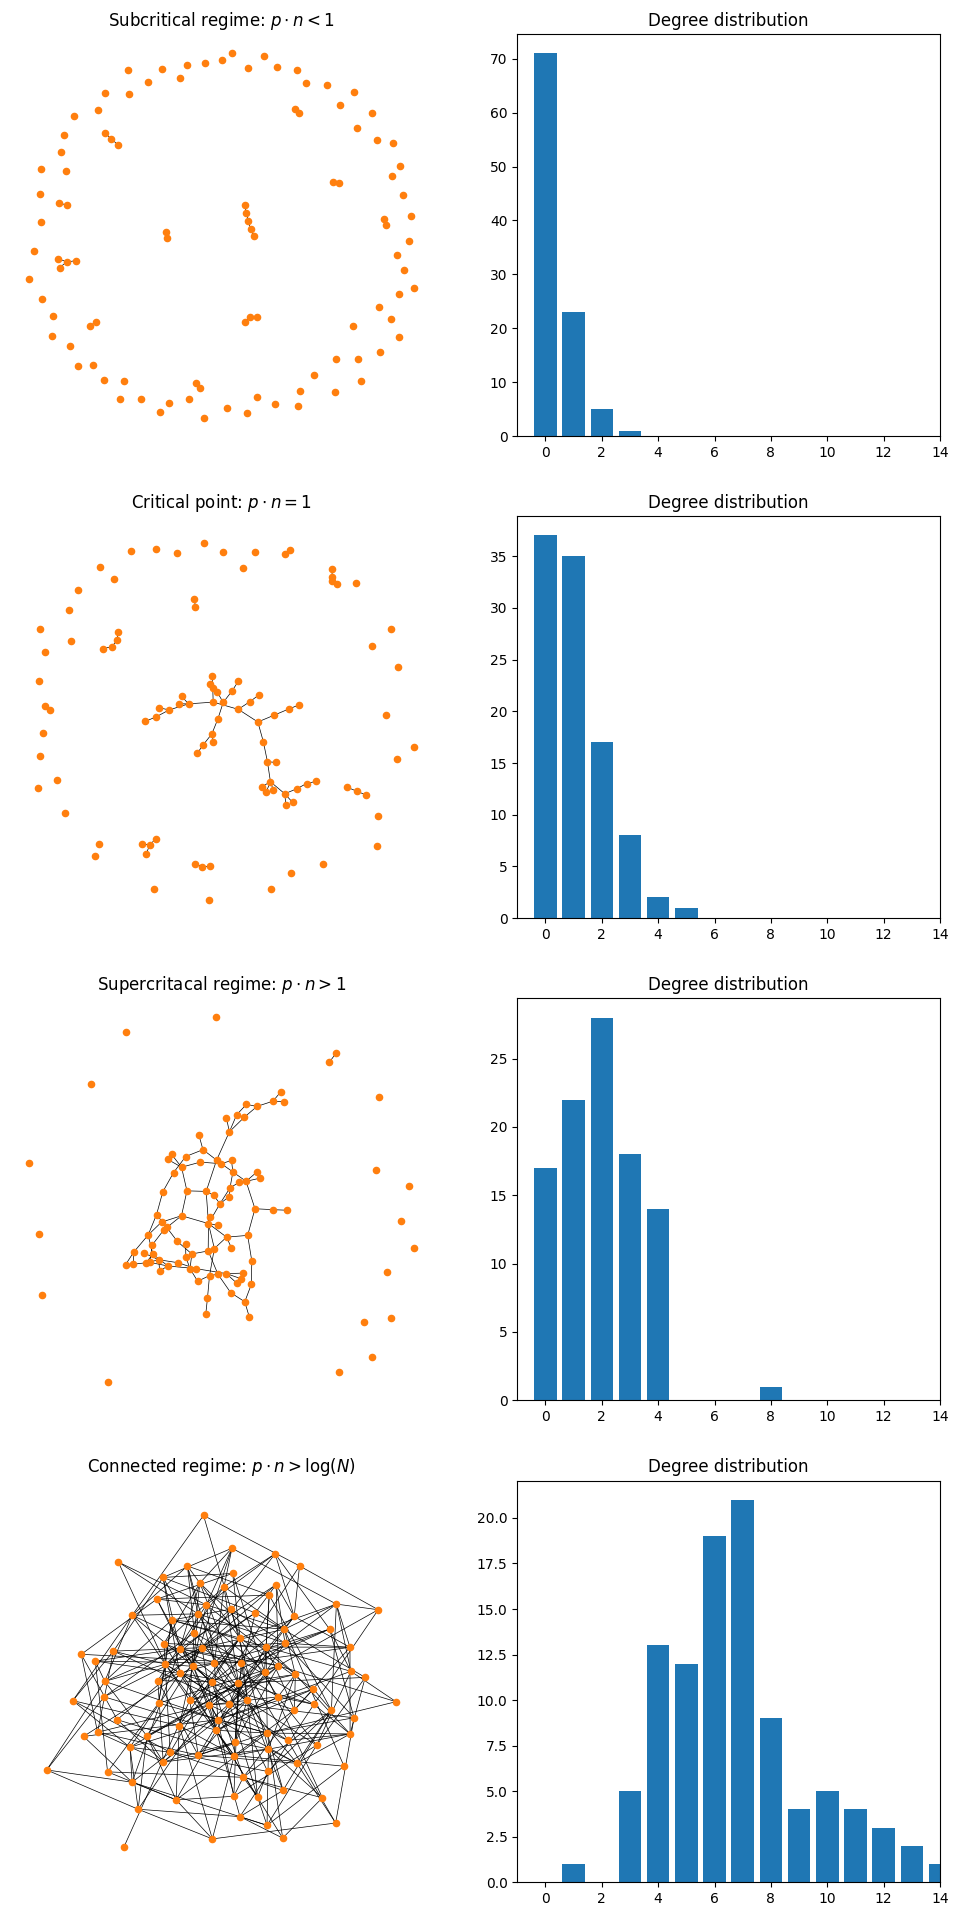

In [5]:
n = 100
cases = [('Subcritical regime: $p \\cdot n < 1$', n, 0.5/n), 
         ('Critical point: $p \\cdot n = 1$', n, 1/n), 
         ('Supercritacal regime: $p \\cdot n > 1$', n, 2/n), 
         ('Connected regime: $p \\cdot n > \\log(N)$', n, 6.5/n)]
plt.figure(figsize=(12, 6 * 4))
i = 1
for regime, n, p in cases:
    plt.subplot(4, 2, i)
    G = erdos_renyi_graph(n, p)
    nx.draw(
        G, 
        with_labels=False, 
        node_size=20, 
        width=0.5, 
        node_color='tab:orange')
    plt.title(regime)
    i += 1
    plt.subplot(4, 2, i)
    degree_seq = [degree for (node, degree) in G.degree]
    bins, freq = np.unique(degree_seq, return_counts=True)
    plt.bar(bins, freq)
    plt.xlim((-1, 14))
    plt.title('Degree distribution')
    i += 1

### Task 2. Fitting parameters of degree distribution (0 points)

In the Erdos-Renyi model, we can estimate a degree distribution using the binomial distribution. The binomial distribution $B(n, p)$ converges to the Poisson $\text{Pois}(\lambda)$ when the number of samples $n$ tends to infinity with the fixed product $np = \lambda$.

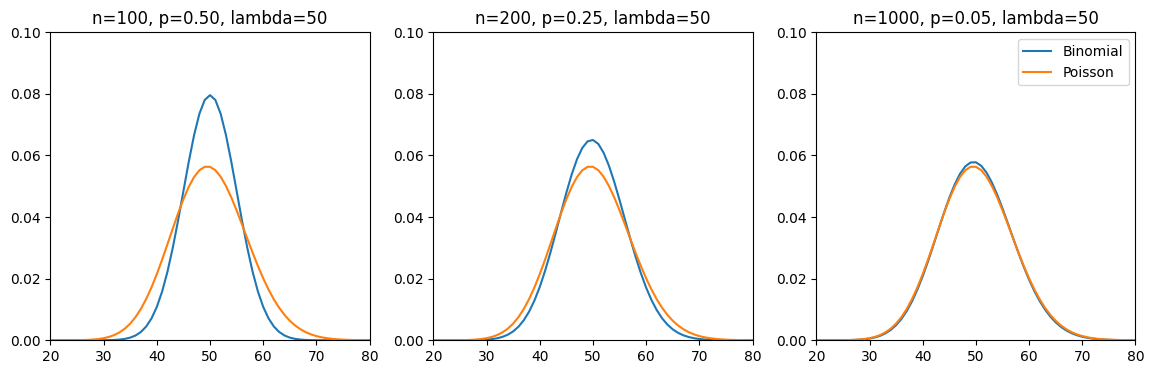

In [6]:
plt.figure(figsize=[14, 4])
for i, [n, mean] in enumerate([[100, 50], [200, 50], [1000, 50]]):
    plt.subplot(1, 3, i+1)
    plt.plot(st.binom(n, mean / n).pmf(np.arange(100)), 
             label="Binomial")
    plt.plot(st.poisson(mean).pmf(np.arange(100)), 
             label="Poisson")
    plt.xlim(20, 80)
    plt.ylim(0, 0.1)
    plt.title('n={}, p={:.2f}, lambda={}'.format(n, mean / n, mean))
plt.legend(loc='upper right');

In this task we will estimate properties of Binomial and Poisson distributions and compare in what cases it is better to use Binomial.

Write a function `estimate_binomial` that takes a random graph and returns binomial parameters `n` and `p`.

In [7]:
def estimate_binomial(G):
    """Estimate the binomial of a graph G with the paramerters of n and p"""
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)
    max_possible_edges = num_nodes * (num_nodes - 1) / 2
    return num_nodes, num_edges / max_possible_edges

In [8]:
G = erdos_renyi_graph(100, 0.5)
n, p = estimate_binomial(G)
assert abs(p - 0.5) <= 0.05
assert n == 100

Write a function `estimate_poisson` that takes a random graph and returns the Poisson parameter $\lambda$ (here denoted as `m`).

In [9]:
def estimate_poisson(G):
    """Estimate the poisson of a graph G with the parameter m (which is lambda but easier to type)"""
    num_nodes = len(G.nodes)
    num_edges = len(G.edges)
    max_possible_edges = num_nodes * (num_nodes - 1) / 2
    p = num_edges / max_possible_edges
    return num_nodes * p

In [10]:
G = erdos_renyi_graph(1000, 0.05)
m = estimate_poisson(G)
assert abs(m - 50) <= 1

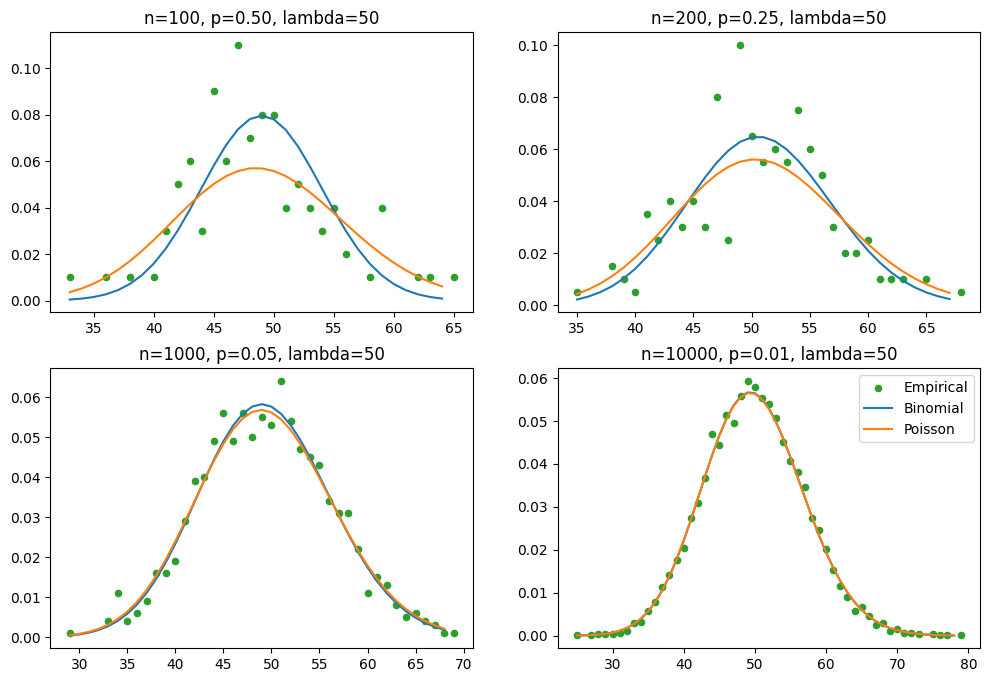

In [11]:
plt.figure(figsize=[12, 8])
for i, [n, p] in enumerate([[100, 0.5], [200, 0.25], [1000, 0.05], [10000, 0.005]]):
    plt.subplot(2, 2, i+1)
    G = erdos_renyi_graph(n, p)
    degree_density = np.array(nx.degree_histogram(G)) / n
    idx = np.argwhere(degree_density > 0)
    plt.scatter(idx, degree_density[idx], label="Empirical", c='tab:green', s=20)
    degrees = dict(G.degree).values()
    k_space = np.arange(min(degrees), max(degrees))
    plt.plot(k_space, st.binom(*estimate_binomial(G)).pmf(k_space), label="Binomial")
    plt.plot(k_space, st.poisson(estimate_poisson(G)).pmf(k_space), label="Poisson")
    plt.title(f'n={n}, p={p:.2f}, lambda={n*p:.0f}')
plt.legend()
plt.show()

### Task 3. Degree distribution of random vs real networks (0 points)

In [12]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/wiki_vote.txt'
open('wiki_vote.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/facebook_combined.txt'
open('facebook_combined.txt', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/collaboration_network_of_arxiv_general_relativity_category.txt'
open('collaboration_network_of_arxiv_general_relativity_category.txt', 'wb').write(requests.get(url).content);


Let us compare degree distributions of real and random networks and decide whether they are close or not.

Write a function `random_from_real` that takes a graph and returns a random network that has the same average node degree and the same number of nodes as a given network. 

In [13]:
def random_from_real(graph):
    n = graph.number_of_nodes()
    m = graph.number_of_edges()
    
    p = m / (n * (n - 1))

    return nx.gnp_random_graph(n, p, directed=True)

In [14]:
for file in ['wiki_vote.txt', 
             'collaboration_network_of_arxiv_general_relativity_category.txt', 
             'facebook_combined.txt']:
    real_net = nx.read_edgelist(file, create_using=nx.DiGraph(), nodetype=int)
    random_net = random_from_real(real_net)
    av_degree_random = np.mean(list(dict(random_net.degree).values()))
    av_degree_real = np.mean(list(dict(real_net.degree).values()))
    assert len(random_net) == len(real_net)
    assert np.abs(av_degree_random - av_degree_real) < 1

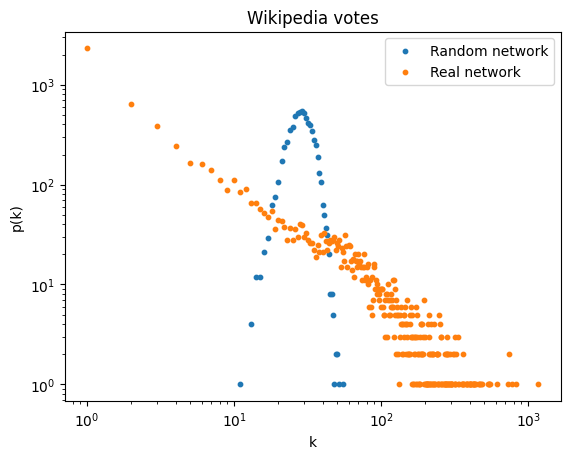

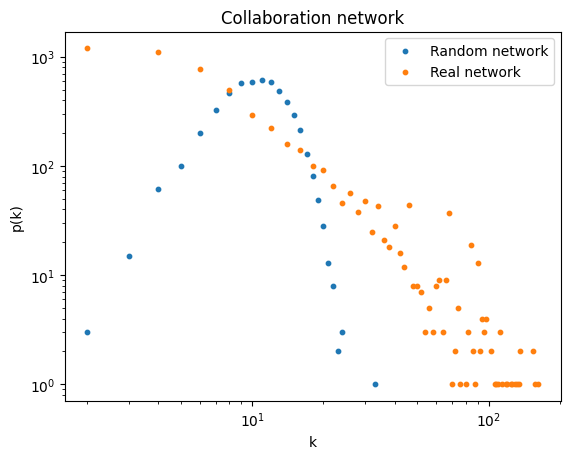

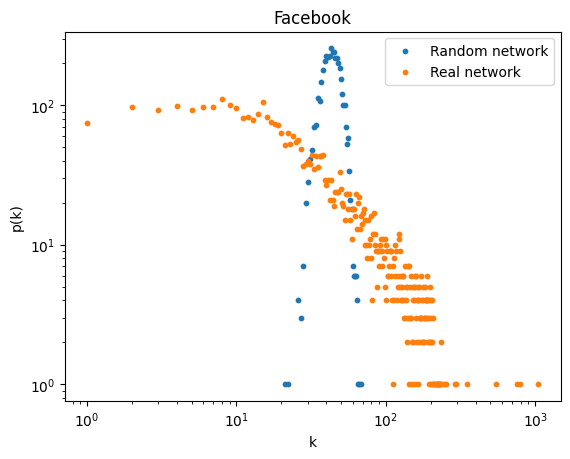

In [15]:
cases = [['Wikipedia votes', 'wiki_vote.txt'], 
         ['Collaboration network', 'collaboration_network_of_arxiv_general_relativity_category.txt'], 
         ['Facebook', 'facebook_combined.txt']]
for title, file in cases:
    real_net = nx.read_edgelist(file, create_using=nx.DiGraph(), nodetype=int)
    random_net = random_from_real(real_net)
    degree_hist = np.array(nx.degree_histogram(random_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Random network')
    degree_hist = np.array(nx.degree_histogram(real_net))
    idx = np.argwhere(degree_hist > 0)
    plt.scatter(idx, degree_hist[idx], s=10, label='Real network')
    plt.legend()
    plt.xlabel('k')
    plt.ylabel('p(k)')
    plt.title(title)
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

### Task 4. Size of components in random graphs (3 points)

Let us see how the size of small components (small — not giant) depends on the probability near the critical point: $p =1/n$.

Write a function `small_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of average sizes of small components.

*Hint: to find nodes in components, use `nx.connected_components(graph)`*

In [16]:
def small_component_size(n, probabilities):
    # set initials
    avg_sizes = []

    # for each probability, get the average size of small components
    for probability in probabilities:
        # create the graph and get the small components
        G = nx.gnp_random_graph(n, probability)
        components = list(nx.connected_components(G))
        components_sorted = sorted(components, key=len, reverse=True)
        small_componets = components_sorted[1:]

        # get the size
        sizes = [len(component) for component in small_componets]
        avg_sizes.append(np.array(sizes).mean())

    return np.array(avg_sizes)


In [17]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
sizes = []
for _ in range(30):
    size = small_component_size(n, p_space)
    assert size.shape == (50,)
    sizes.append(size)

av_sizes = np.mean(sizes, axis=0)
assert av_sizes[0] < av_sizes[np.argmin(np.abs(p_space*n - 1))]
assert av_sizes[49] < av_sizes[np.argmin(np.abs(p_space*n - 1))]

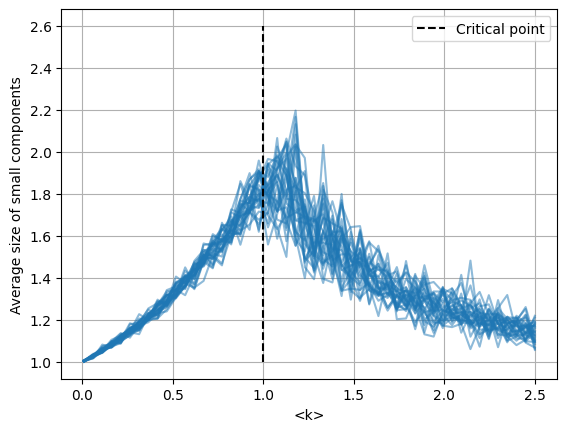

In [18]:
for i in range(len(sizes)):
    plt.plot(p_space*n, sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [1, 2.6], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Average size of small components')
plt.legend()
plt.grid()
plt.show()

We interpret the peak at $\langle k \rangle$ because as the average node degree increases to 1, the components gradually become more connected. However, after the critical point, the giant component takes most of the nodes, so the small components' size becomes smaller on average.

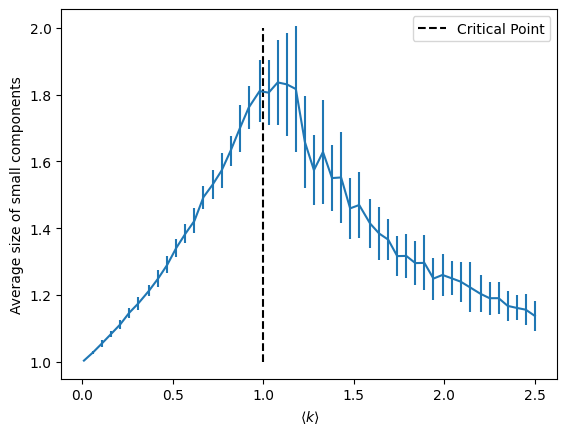

In [19]:
import pandas as pd
sizes_df = pd.DataFrame(sizes, columns=np.round(n*p_space, 2))
plt.errorbar(sizes_df.columns, sizes_df.mean(), yerr=sizes_df.std())
plt.plot([1, 1], [1, 2], 'k--', label='Critical Point')
plt.xlabel(r'$\langle k \rangle$')
plt.legend()
plt.ylabel('Average size of small components')
plt.show()

Also let us see how the size of a giant component depends on the probability near the critical point.

Write a function `giant_component_size` with parameters `n` — number of nodes, `probabilities` — np.array of probabilities. The function generates a random graph for each probability and returns np.array of sizes of a giant component.

*Hint: to find nodes in a ginat component, use `max(nx.connected_components(graph), key=len)`*

In [20]:
def giant_component_size(n, probabilities):
    gc_sizes = []

    for probability in probabilities:
        G = nx.gnp_random_graph(n, probability)
        gcc = max(nx.connected_components(G), key=len)
        gc_sizes.append(len(gcc))
    
    return np.array(gc_sizes)

In [21]:
n = 1000
p_space = np.linspace(0.01/n, 2.5/n, 50)
gcc_sizes = []
for _ in range(30):
    size = giant_component_size(n, p_space)
    assert size.shape == (50,)
    gcc_sizes.append(size)

av_sizes = np.mean(gcc_sizes, axis=0)
assert av_sizes[0] < 20
assert 20 < av_sizes[np.argmin(np.abs(p_space*n - 1))] < 150
assert 700 < av_sizes[np.argmin(np.abs(p_space*n - 2))] < 900

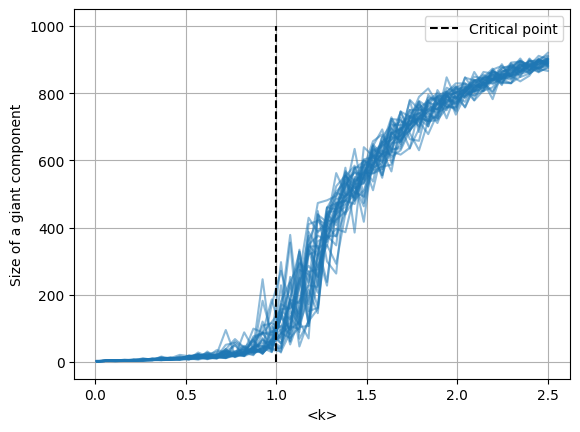

In [25]:
for i in range(30):
    plt.plot(p_space*n, gcc_sizes[i], c='tab:blue', alpha=0.5)
plt.plot([1, 1], [0, 1000], 'k--', label='Critical point')
plt.xlabel('<k>')
plt.ylabel('Size of a giant component')
plt.legend()
plt.grid()
plt.show()

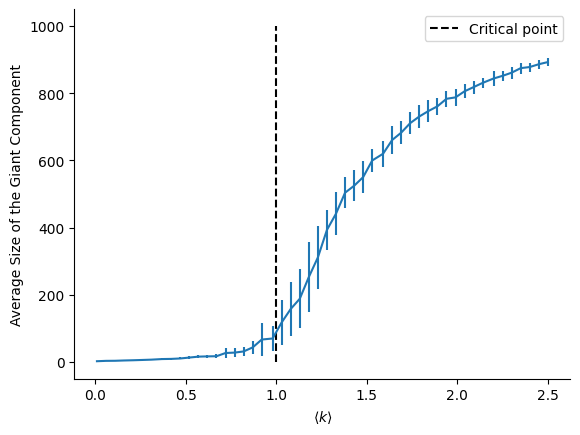

In [26]:
gcc_df = pd.DataFrame(gcc_sizes, columns=np.round(n*p_space, 2))
plt.errorbar(x=gcc_df.columns, y=gcc_df.mean(), yerr=gcc_df.std())
plt.plot([1, 1], [0, 1000], 'k--', label='Critical point')
plt.xlabel(r'$\langle k \rangle$')
plt.ylabel('Average Size of the Giant Component')
plt.legend()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

### Task 5. Average path length in random graphs (2 points)

In this task, we consider whether a random network is capable to model the small world phenomenon, also known as six degrees of separation — the distance between two randomly chosen nodes in a network is short. In other words, the average path length between two randomly chosen nodes increases in a growing network, but not so fast as the number of nodes.

Write a function `growing_path_len` with parameters: `av_node_degree` is an average node degree and `n_nodes` is a np.array of numbers of nodes. The function generates a random network for each number of nodes and returns a np.array of average path lengths.

*Hints:*
* *To calculate average path length, use `nx.average_shortest_path_length`*
* *Consider a giant component only*
* *To find nodes in a ginat component, use `max(nx.connected_components(graph), key=len)`*
* *To create a subgraph, use `graph.subgraph(nodes).copy()`*

In [27]:
def growing_path_len(av_node_degree, n_nodes):
    probabilities = av_node_degree / n_nodes
    avg_paths = []

    for n, p in zip(n_nodes, probabilities):
        graph = nx.gnp_random_graph(n, p)
        gcc_nodes = max(nx.connected_components(graph), key=len)
        gcc_graph = graph.subgraph(gcc_nodes).copy()
        avg_path_length = nx.average_shortest_path_length(gcc_graph)
        avg_paths.append(avg_path_length)
    
    return np.array(avg_paths)

In [28]:
n_nodes = np.arange(100, 1100, 100)
av_node_degree = 50
lengths = growing_path_len(av_node_degree, n_nodes)

assert lengths.shape == (10,)
assert 1.4 < lengths[0] < 1.6
assert 1.9 < lengths[5] < 1.95
assert 2 < lengths[9] < 2.1

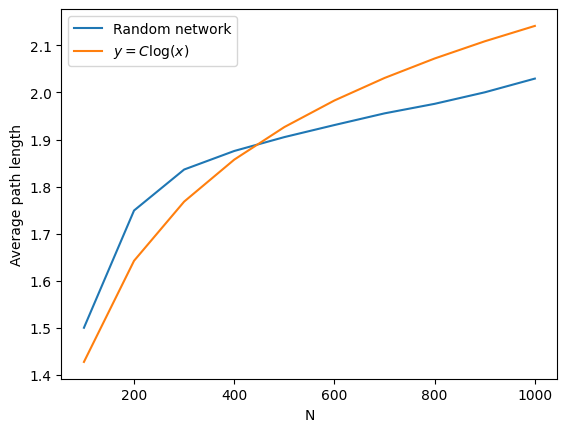

In [29]:
plt.plot(n_nodes, lengths, label='Random network')
plt.xlabel('N')
plt.ylabel('Average path length')
plt.plot(n_nodes, 0.31 * np.log(n_nodes), label=r'$y=C\log(x)$')
plt.legend()
plt.show()

As we see, the small world phenomenon holds — the average path length increases at most logarithmically with respect to the number of nodes. Theoretically, the diameter $d_{\max}$ in a random network is

$$d_{\max} \approx \frac{\ln N}{\ln \langle k \rangle}$$

that corresponds to some real scale-free networks.

### Task 6. Clustering coefficients of random vs real networks (3 points)

Clustering coefficient of a node $C_i$ contains information about relationship between nearest neighbors.  $C_i = 0$ means that there is no links between neighbors and $C_i = 1$ means that there are all possible links between them. Clustering coefficient of an Erdos-Renyi random graph is equal to the probability $p$ and does not dependent of a node and its degree:

$$C_i = \langle C \rangle = \frac{\langle k \rangle}{n} = p $$

Let us check it on generated data.

Write a function `node_degree_clustering` with parameters `n, p` — number of nodes and probability. The function generates Erdos-Renyi random graph and returns a tuple with two np.arrays: degrees and clustering coefficients. Ordering of elements should coincide: the first degree and first clustering coefficient are related to the first node and so on.

*Hint: to calculate clustering coefficients, use `nx.clustering(graph)`*

In [36]:
def node_degree_clustering(n, p):
    # Set the variables
    G = nx.gnp_random_graph(n, p)

    degrees = []
    degrees_pre_made = G.degree

    clusterings = []
    clustering_pre_made = nx.clustering(G)

    # for each node, get its degree and clustering coefficient
    for node in range(G.number_of_nodes()):
        degrees.append(degrees_pre_made[node])
        clusterings.append(clustering_pre_made[node])
    
    return np.array(degrees), np.array(clusterings)


In [37]:
p = 0.9
n = 100
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()
p = 0.01
n = 3000
degree, clustering = node_degree_clustering(n, p)
assert degree.shape == clustering.shape
assert clustering.mean() - 3*clustering.std() < p < clustering.mean() + 3*clustering.std()
assert degree.mean() - 3*degree.std() < p * n < degree.mean() + 3*degree.std()

Let us draw the dependency between node degree and clustering coefficient.

Cloud-like distribution:

* The points are scattered densely around a horizontal band, centered roughly around a clustering coefficient of 0.1.

* This suggests little to no clear correlation between node degree and clustering coefficient. Nodes with higher degree do not necessarily have higher or lower clustering.

Dashed horizontal line (legend: “Probability”):

* This line is likely indicating the expected clustering coefficient under some null model, possibly an Erdős–Rényi random graph model or a configuration model.

* Since the actual data points (blue dots) are distributed closely around this line, it implies that the network’s local clustering is roughly what you’d expect by chance.

Implications:
* This plot could be used to show that there’s no strong hierarchical or modular structure affecting local clustering in the graph.

* It might also suggest that the network behaves similarly to a random graph, where clustering isn’t significantly enhanced by degree or local structure.



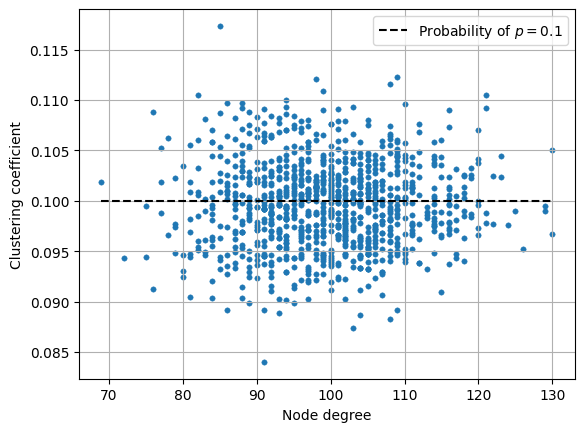

In [40]:
p = 0.1
n = 1000
degree, clustering = node_degree_clustering(n, p)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.plot([degree.min(), degree.max()], [p, p], 'k--', label='Probability of $p = 0.1$')
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.legend()
plt.grid()
plt.show()

Let us look at the dependency of a some real social network.

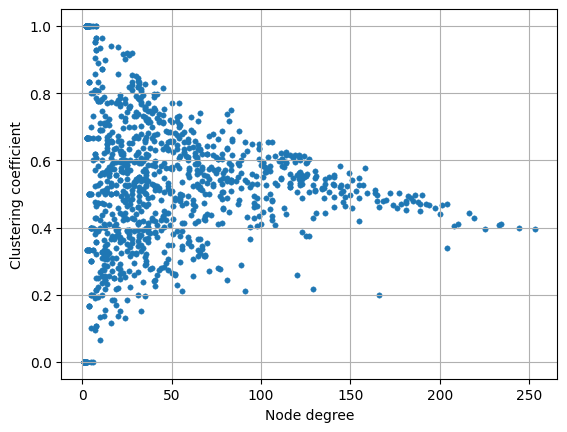

In [41]:
degree = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/real_net_degree.txt'
)
clustering = np.loadtxt(
    'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/real_net_clustering.txt'
)
plt.scatter(degree, clustering, s=15, linewidths=0.3)
plt.xlabel('Node degree')
plt.ylabel('Clustering coefficient')
plt.grid()
plt.show()

We can see that the average clustering coefficient slightly decreases in high degrees. 

Node Degree: This refers to the number of connections a node (or point) has in a network. Nodes with high degrees are "hubs."

Clustering Coefficient: This measures how interconnected a node's neighbors are. A high clustering coefficient (close to 1) means that if node A is connected to B and C, then B and C are also likely to be connected to each other (they form a "cluster" or "triangle"). A low coefficient means A's neighbors are not necessarily connected to each other.
The Trend: The plot shows a general downward trend: as the node degree increases (moving right on the x-axis), the clustering coefficient tends to decrease (moving down on the y-axis). This means that high-degree nodes (hubs) tend to have lower clustering coefficients.
What to do with this (Interpretation and Next Steps):

Interpret the finding: This pattern is characteristic of many real-world networks (often called "scale-free networks"). It suggests that while hubs are highly connected, their connections are more likely to be to diverse parts of the network rather than just to a tightly knit group of their immediate neighbors. In contrast, low-degree nodes are often part of very dense, tightly clustered groups.

### Task 7. Snobbish networks (2 points)

Consider a network of $N$ red and $N$ blue nodes. The probability that there is a link between nodes of identical color is $p$ and the probability that there is a link between nodes of different color is $q$. A network is snobbish if $p>q$, capturing a tendency to connect to nodes of the same color. For $q = 0$ the network has at least two components, containing nodes with the same color.

Write a function `snobbish_network` that takes the number of red (or blue) nodes `n`, probability of link between nodes of the same color `p` and probability of link between nodes of different color `q`. The function returns a network with $2N$ nodes where every node has an attribute `color` that can be `blue` or `red`.

*Hint: to set node attributes, use `nx.set_node_attributes`*

In [71]:
def snobbish_network(n, p, q):
    # Set up the variables needed for stochastic_block_model
    sizes = [n, n]
    probabilities = [[p, q], # red to red; red to blue
                     [q, p]] # blue to red; blue to blue
    G = nx.stochastic_block_model(sizes, probabilities)

    # Set up the node attributes
    node_attributes = {i:'red' if i < n else 'blue' for i in range(G.number_of_nodes())}
    nx.set_node_attributes(G, node_attributes, name='color')
    
    return G

In [72]:
sn_net = snobbish_network(100, 0.1, 0.01)
assert sn_net.number_of_nodes() == 200
assert set(nx.get_node_attributes(sn_net, 'color').values()) == {'blue', 'red'}
assert np.sum(np.array(list(nx.get_node_attributes(sn_net, 'color').values())) == 'red') == 100
assert 0.76 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.88
sn_net = snobbish_network(200, 0.1, 0.05)
assert 0.25 < nx.attribute_assortativity_coefficient(sn_net, 'color') < 0.4

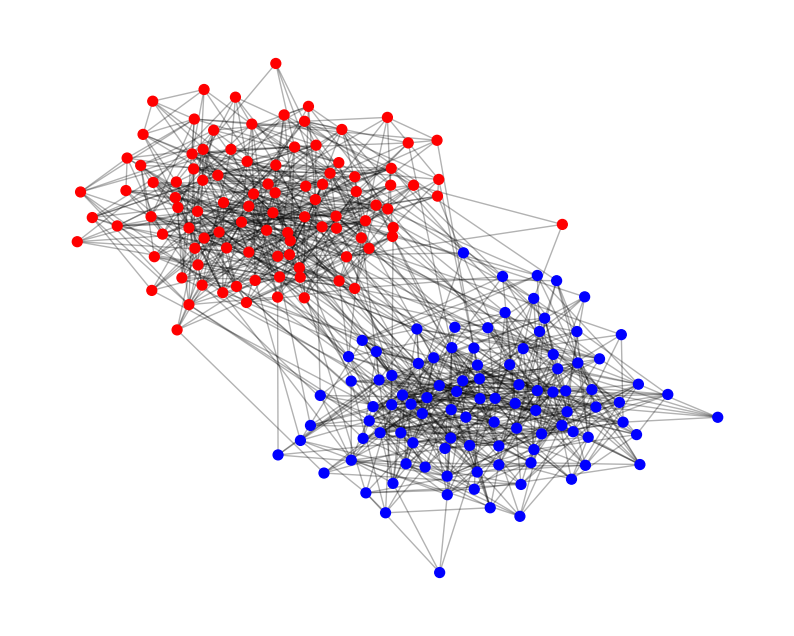

In [73]:
plt.figure(figsize=(10, 8))
sn_net = snobbish_network(100, 0.1, 0.01)
pos = nx.spring_layout(sn_net)
nx.draw_networkx_nodes(
    sn_net, 
    pos=pos,
    node_color=nx.get_node_attributes(sn_net, 'color').values(), 
    node_size=50)
nx.draw_networkx_edges(sn_net, pos=pos, alpha=0.3)
plt.axis('off')
plt.show()